In [65]:
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

import os
os.chdir('../src')

from specs import m_to_label

### Gather all results

In [24]:
metadata_comp = []
metadata_nh2015 = []
metadata_rsanh2015 = []
metadata_rsab2021 = []
for f in tqdm(Path('../results/voxel_prediction/NH2015comp').glob('*.pkl')):
    data = joblib.load(f)
    model = f.stem.split('NH2015comp_')[-1]
    model_metadata = {'model': model}
    for row in data:
        model_metadata['comp_{}'.format(row['voxel_id'])] = row['metrics'][0]
    metadata_comp.append(model_metadata)
        
for f in tqdm(Path('../results/voxel_prediction/NH2015').glob('*.pkl')):
    data = joblib.load(f)
    model = f.stem.split('NH2015_')[-1]
    model_metadata = {'model': model}
    for row in data:
        model_metadata['nh2015_{}'.format(row['voxel_id'])] = row['metrics'][0]
    metadata_nh2015.append(model_metadata)

for f in tqdm(Path('../results/rsa/NH2015').glob('*.pkl')):
    subjects_rsa = joblib.load(f)['subjects_r']
    rsa_val = np.nanmean(subjects_rsa)
    rsa_std = np.nanstd(subjects_rsa)
    model = f.stem.split('RSA_NH2015_')[-1]
    model_metadata = {'model': model,
                      'rsa_nh2015': rsa_val,
                      'rsa_nh2015_std': rsa_std}
    metadata_rsanh2015.append(model_metadata)
    
for f in tqdm(Path('../results/rsa/B2021').glob('*.pkl')):
    subjects_rsa = joblib.load(f)['subjects_r']
    rsa_val = np.nanmean(subjects_rsa)
    rsa_std = np.nanstd(subjects_rsa)
    model = f.stem.split('RSA_B2021_')[-1]
    model_metadata = {'model': model,
                      'rsa_b2021': rsa_val,
                      'rsa_b2021_std': rsa_std}
    metadata_rsab2021.append(model_metadata)

df_comp = pd.DataFrame(metadata_comp).set_index('model')
df_nh2015 = pd.DataFrame(metadata_nh2015).set_index('model')
df_rsa_nh2015 = pd.DataFrame(metadata_rsanh2015).set_index('model')
df_rsa_b2021 = pd.DataFrame(metadata_rsab2021).set_index('model')

df_all = pd.concat([df_comp, df_nh2015, df_rsa_nh2015, df_rsa_b2021], axis=1)

37it [00:00, 227.24it/s]
38it [05:57,  9.40s/it]
37it [00:00, 1090.92it/s]
37it [00:00, 610.54it/s]


### NH2015

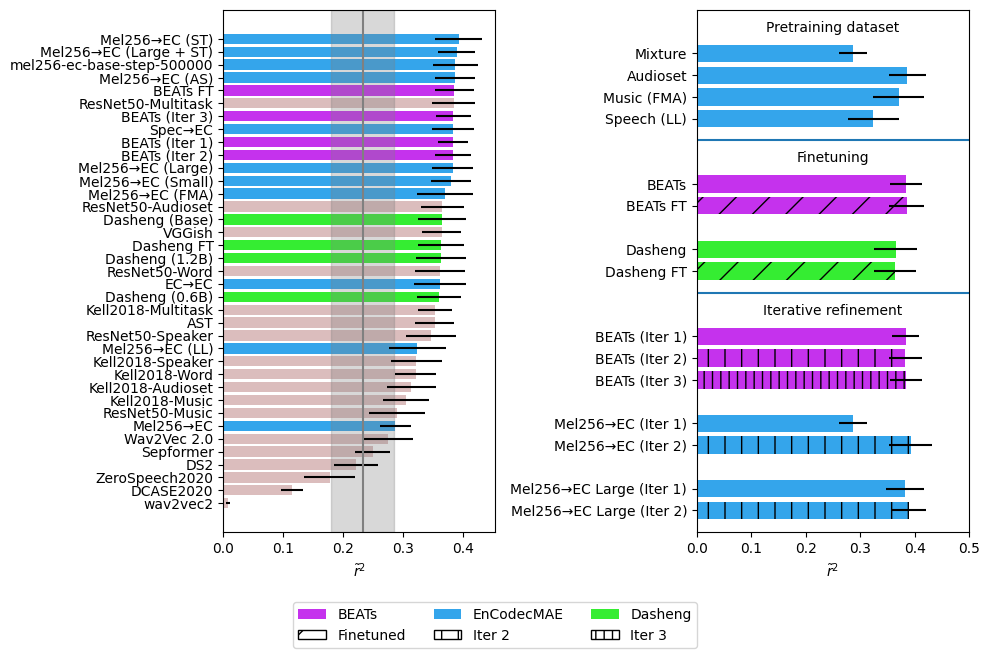

In [85]:
df_voxel_metadata = pd.DataFrame(np.load('../../tp-picml/auditory_brain_dnn/data/neural/NH2015/voxel_features_meta.npy')).reset_index()

subj_medians = []
for subj in df_voxel_metadata['subj_idx'].unique():
    cols = [f'nh2015_{xi}' for xi in df_voxel_metadata.loc[df_voxel_metadata['subj_idx']==subj]['index'].values if f'nh2015_{xi}' in df_all.columns]
    subj_median_r2 = df_all[cols].median(axis=1)
    subj_medians.append(subj_median_r2)

r2_mean = pd.concat(subj_medians, axis=1).mean(axis=1)
r2_std = pd.concat(subj_medians, axis=1).std(axis=1)

r2_nh2015 = pd.concat([r2_mean, r2_std], axis=1)
r2_nh2015.columns = ['r2_mean', 'r2_std']

r2_nh2015 = r2_nh2015.sort_values('r2_mean')

def assign_color(x):
    if '-ec' in x:
        return '#34a5eb'
    elif 'dasheng' in x:
        return '#35ed32'
    elif 'BEATs' in x:
        return '#c532ed'
    else:
        return '#dbbdbd'

fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)
spectemp = r2_nh2015.loc['spectemp']
r2_nh2015 = r2_nh2015.drop(index='spectemp')
ax[0].barh(y=r2_nh2015.index.map(lambda x: m_to_label[x] if x in m_to_label else x), 
           width=r2_nh2015['r2_mean'], 
           xerr=r2_nh2015['r2_std'],
           color=r2_nh2015.index.map(assign_color))
ax[0].axvline(spectemp['r2_mean'], c='gray')
ax[0].axvspan(spectemp['r2_mean']-spectemp['r2_std'], spectemp['r2_mean']+spectemp['r2_std'], color='gray', alpha=0.3)

model_domains = ['mel256-ec-base', 'mel256-ec-base-as', 'mel256-ec-base-fma', 'mel256-ec-base-ll']
df_domains = r2_nh2015.loc[model_domains]

labels = ['Mixture', 'Audioset', 'FMA', 'LL']
ax[1].barh(y=[19,18,17,16], 
           width = df_domains['r2_mean'], 
           color=['#34a5eb']*4,
           xerr=df_domains['r2_std'])
ax[1].set_xlim([0,0.5])
ax[1].set_ylim([-3,21])
ax[1].set_yticks(ticks=[19,18,17,16],labels=labels, fontsize=10)
ax[1].axhline(15)

ax[1].text(0.25,20,'Pretraining dataset', fontsize=10, ha='center')
ax[1].text(0.25,14,'Finetuning', fontsize=10, ha='center')
ax[1].text(0.25,7,'Iterative refinement', fontsize=10, ha='center')
model_ft = ['BEATs_iter3', 'BEATs_iter3_finetuned_on_AS2M_cpt1', 'dasheng_base', 'dasheng_base_ft-as']
df_ft = r2_nh2015.loc[model_ft]

labels = ['BEATs', 'BEATs + FT','Dasheng', 'Dasheng + FT']
xpos = [13,12,10,9]
ax[1].barh(y=xpos, 
           width = df_ft['r2_mean'],
           xerr = df_ft['r2_std'],
           color=['#c532ed','#c532ed','#35ed32','#35ed32'],
           hatch=['','/','','/'])
ax[1].set_yticks(ticks=[13.5,11.5],labels=['BEATs','Dasheng'], fontsize=10)
ax[1].axhline(8)

custom_legend = [
    Patch(facecolor='b', label='Base'),
    Patch(facecolor='r', label='Finetuned'),
]

model_iter = ['BEATs_iter1','BEATs_iter2','BEATs_iter3','mel256-ec-base', 'mel256-ec-base_st-nopn', 'mel256-ec-large', 'mel256-ec-large_st-nopn']
df_iter = r2_nh2015.loc[model_iter]

labels = ['BEATs It1','BEATs It2','BEATs It3', 'EnCodecMAE Base It1', 'EnCodecMAE Base It2','EnCodecMAE Large It1', 'EnCodecMAE Large It2']
xpos = [6,5,4,2,1,-1,-2]
ax[1].barh(y=xpos, 
           width = df_iter['r2_mean'],
           xerr = df_iter['r2_std'],
           color=['#c532ed','#c532ed','#c532ed','#34a5eb','#34a5eb','#34a5eb','#34a5eb'],
           hatch=['','|','||','','|','','|'])

custom_legend = [
    Patch(facecolor='b', label='1'),
    Patch(facecolor='g', label='2'),
    Patch(facecolor='r', label='3')
]

ax[1].set_yticks(ticks=[19,18,17,16,13,12,10,9,6,5,4,2,1,-1,-2],
                 labels=['Mixture',
                         'Audioset',
                         'Music (FMA)',
                         'Speech (LL)',
                         'BEATs',
                         'BEATs FT',
                         'Dasheng',
                         'Dasheng FT',
                         'BEATs (Iter 1)',
                         'BEATs (Iter 2)',
                         'BEATs (Iter 3)',
                         'Mel256→EC (Iter 1)',
                         'Mel256→EC (Iter 2)',
                         'Mel256→EC Large (Iter 1)',
                         'Mel256→EC Large (Iter 2)'])

custom_legend = [
    Patch(facecolor='#c532ed', label='BEATs'),
    Patch(facecolor='white', edgecolor='black', hatch='/', label='Finetuned'),
    Patch(facecolor='#34a5eb', label='EnCodecMAE'),
    Patch(facecolor='white', edgecolor='black', hatch='|', label='Iter 2'),
    Patch(facecolor='#35ed32', label='Dasheng'),
    Patch(facecolor='white', edgecolor='black', hatch='||', label='Iter 3'),
]

fig.legend(handles=custom_legend, ncols=3, loc='lower center', bbox_to_anchor=[0.5,-0.1,0,0])
ax[0].set_xlabel(r'$\tilde{r}^2$')
ax[1].set_xlabel(r'$\tilde{r}^2$')
plt.tight_layout()

### NH2015comp

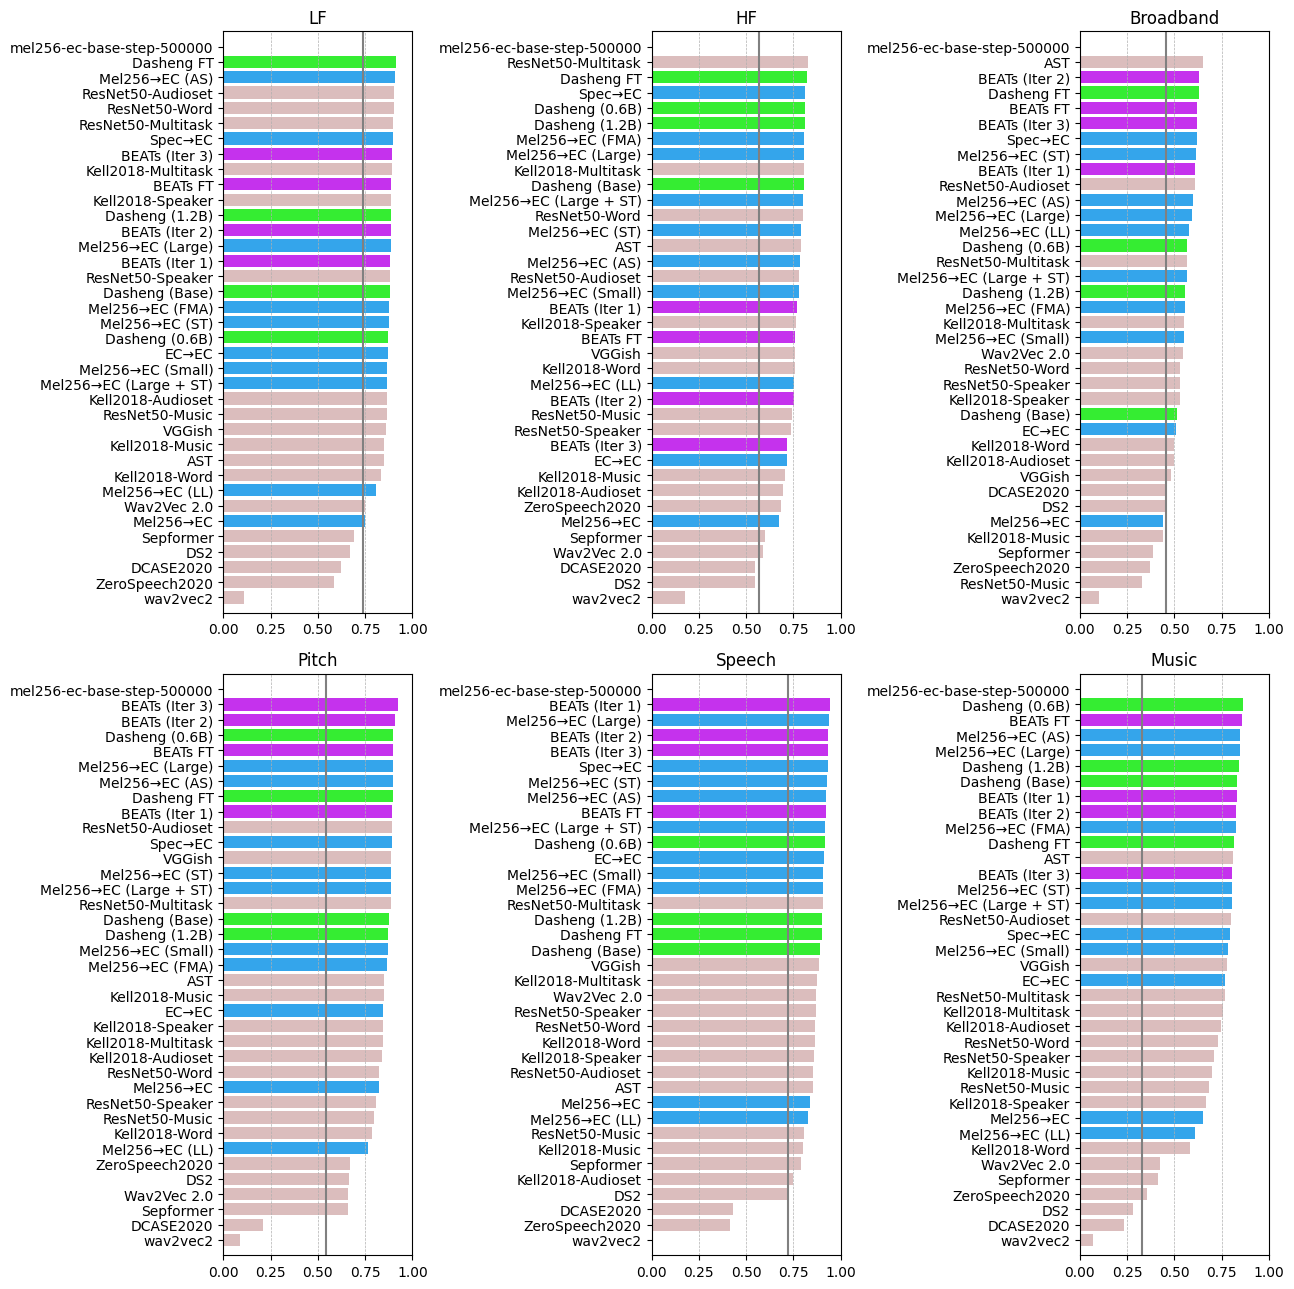

In [95]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13,13))

df_comp = df_all[[c for c in df_all.columns if c.startswith('comp_')]]
c_to_title = ['LF', 'HF', 'Broadband', 'Pitch', 'Speech', 'Music']
for i in range(6):
    df_compi = df_comp[f'comp_{i}']
    df_compi = df_compi.sort_values()
    spectemp = df_compi.loc['spectemp']
    df_compi = df_compi.drop(index='spectemp')
    model = df_compi.index.map(lambda x: m_to_label[x] if x in m_to_label else x)
    color = df_compi.index.map(lambda x: assign_color(x))
    
    ax[i//3,i%3].barh(y=model, width=df_compi.values, color=color)
    ax[i//3,i%3].axvline(spectemp, color='gray')
    ax[i//3,i%3].set_xlim(0,1)
    ax[i//3,i%3].set_title(c_to_title[i])
    ax[i//3,i%3].set_ylim(-1,37)
    ax[i//3,i%3].xaxis.grid(True, linestyle='--', linewidth=0.5, alpha=1)
    ax[i//3,i%3].yaxis.grid(False)  # optional: turn off horizontal gridlines

plt.tight_layout()

### RSA

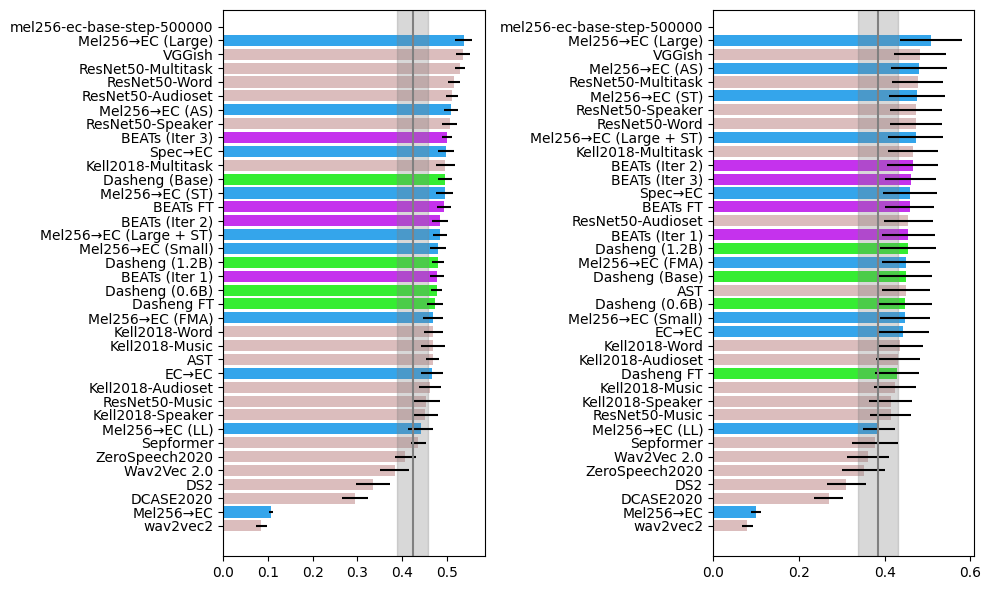

In [106]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

df_rsa = df_all[['rsa_nh2015', 'rsa_nh2015_std']]
df_rsa = df_rsa.sort_values('rsa_nh2015')
rsa_spectemp = df_rsa.loc['spectemp']
df_rsa = df_rsa.drop(index='spectemp')
ax[0].barh(y=df_rsa.index.map(lambda x: m_to_label[x] if x in m_to_label else x),
           width=df_rsa['rsa_nh2015'],
           xerr=df_rsa['rsa_nh2015_std'],
           color=df_rsa.index.map(assign_color))
ax[0].axvline(rsa_spectemp['rsa_nh2015'], c='gray')
ax[0].axvspan(rsa_spectemp['rsa_nh2015']-rsa_spectemp['rsa_nh2015_std'], 
              rsa_spectemp['rsa_nh2015']+rsa_spectemp['rsa_nh2015_std'], 
              color='gray', alpha=0.3)

df_rsa = df_all[['rsa_b2021', 'rsa_b2021_std']]
df_rsa = df_rsa.sort_values('rsa_b2021')
rsa_spectemp = df_rsa.loc['spectemp']
df_rsa = df_rsa.drop(index='spectemp')
ax[1].barh(y=df_rsa.index.map(lambda x: m_to_label[x] if x in m_to_label else x),
           width=df_rsa['rsa_b2021'],
           xerr=df_rsa['rsa_b2021_std'],
           color=df_rsa.index.map(assign_color))
ax[1].axvline(rsa_spectemp['rsa_b2021'], c='gray')
ax[1].axvspan(rsa_spectemp['rsa_b2021']-rsa_spectemp['rsa_b2021_std'], 
              rsa_spectemp['rsa_b2021']+rsa_spectemp['rsa_b2021_std'], 
              color='gray', alpha=0.3)

plt.tight_layout()